In [1]:
import warnings
warnings.filterwarnings('ignore')

import requests
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from talib import WMA
from tqdm import tqdm
from scipy.stats import mstats
from scipy.signal import argrelextrema
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import yfinance as yf

import calc_functions as u
import alpha_generation as fg

# Set random seed
np.random.seed(0)
tf.random.set_seed(0)


## This notebook aims to generate WorldQuant's 101 alphas and use it as features for our ML model
    

>“An alpha is a combination of mathematical expressions, computer source code, and configuration parameters
> that can be used, in combination with historical data, to make predictions about future movements of various
> financial instruments"

[Finding Alphas: A Quantitative Approach to Building Trading Strategies](https://books.google.com/books?hl=en&lr=&id=ntuuDwAAQBAJ&oi=fnd&pg=PR11&dq=Finding+Alphas:+A+Quantitative+Approach+to+Building+Trading+Strategies&ots=nQrqbJlQu1&sig=FWfLI0_AIJWiNJ3D6tE0twHjj5I#v=onepage&q=Finding%20Alphas%3A%20A%20Quantitative%20Approach%20to%20Building%20Trading%20Strategies&f=false), Igor Tulchinsky, 2019

## Get data from binance

In [2]:
# # LIST OF BINANCE URLS AVAIL
# # GET /api/v3/klines
# # GET /api/v3/uiKlines
# # <symbol>@miniTicker
# # <symbol>@ticker

# # data format for reference
# # [
# #   [
# #     1499040000000,      // Kline open time
# #     "0.01634790",       // Open price
# #     "0.80000000",       // High price
# #     "0.01575800",       // Low price
# #     "0.01577100",       // Close price
# #     "148976.11427815",  // Volume
# #     1499644799999,      // Kline Close time
# #     "2434.19055334",    // Quote asset volume
# #     308,                // Number of trades
# #     "1756.87402397",    // Taker buy base asset volume
# #     "28.46694368",      // Taker buy quote asset volume
# #     "0"                 // Unused field, ignore.
# #   ]
# # ]

# base_url = "https://api.binance.com/api/v3/klines"

# # Function to fetch hourly data from Binance
# def fetch_binance_data(symbol, interval, start_time, end_time):
#     params = {
#         'symbol': symbol,
#         'interval': interval,
#         'startTime': int(start_time.timestamp() * 1000),
#         'endTime': int(end_time.timestamp() * 1000),
#     }
#     response = requests.get(base_url, params=params)
#     data = response.json()
#     return data

# # Function to convert Binance data to DataFrame
# def binance_data_to_dataframe(data):
#     # From klines in binance API
#     df = pd.DataFrame(data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 
#                                      'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 
#                                      'Taker Buy Quote Asset Volume', 'Ignore'])
    
#     # Convert timestamp to datetime
#     df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
#     df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
#     # remove IGNORE column 
#     df = df.drop(columns=['Ignore'])
#     return df

# # Parameters set
# symbol = "BTCUSDT"
# interval = "1d"
# end_time = datetime.now()
# start_time = end_time - relativedelta(months=60)  # 3 months ago, either this or 90 days

# btcusdt_data = pd.DataFrame()

# # There is a limit of 500 fetches per query, hence I used a loop to fetch data for past 3 months
# while start_time < end_time:
#     fetched_data = fetch_binance_data(symbol, interval, start_time, end_time)
    
#     df = binance_data_to_dataframe(fetched_data)

#     if not df.empty:
#         btcusdt_data = pd.concat([btcusdt_data, df])
#         start_time = pd.to_datetime(df['Close Time'].iloc[-1]) + timedelta(hours=1)
#     else:
#         break
        
# btcusdt_data = btcusdt_data.reset_index(drop=True)
# btcusdt_data = btcusdt_data.drop(columns=['Close Time'])
# btcusdt_data.to_csv('./BTCUSDT_Hourly.csv', index=True) 

# columns_to_convert = {
#     'Open': float,
#     'High': float,
#     'Low': float,
#     'Close': float,
#     'Volume': float,
#     'Quote Asset Volume': float,
#     'Number of Trades': int,
#     'Taker Buy Base Asset Volume': float,
#     'Taker Buy Quote Asset Volume': float
# }

# btcusdt_data = btcusdt_data.astype(columns_to_convert)
# btcusdt_data = btcusdt_data.set_index(['Open Time'])
# btcusdt_data

ticker = "AAPL"
df = yf.download(ticker, start="2012-01-01", interval='1d')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655558,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787853,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400


In [3]:
#df = df[df.columns[:5]]
#df.columns = df.columns.str.lower()
df['vwap'] = u.vwap(df)
df['returns'] = u.returns(df)
df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,vwap,returns
Date,,,,,,,,
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000,14.765714,0.005374
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655558,271269600,14.929643,0.011102
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787853,318292800,15.085714,0.010454
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400,15.061786,-0.001586
2012-01-10,15.211071,15.214286,15.053571,15.115714,12.813284,258196400,15.115714,0.003580
...,...,...,...,...,...,...,...,...
2023-12-18,196.089996,196.630005,194.389999,195.889999,195.889999,55751900,195.889999,-0.008503
2023-12-19,196.160004,196.949997,195.889999,196.940002,196.940002,40714100,196.940002,0.005360
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800,194.830002,-0.010714


In [4]:
unavailable = {48, 56, 58, 59, 63, 67, 69, 70, 76, 79, 80, 82, 87, 89, 90, 91, 93, 97, 100}

df = fg.generate_101_alphas(df, unavailable)
df


Processing Alphas: 100%|████████████████████████| 101/101 [00:07<00:00, 13.23it/s]


,Open,High,Low,Close,Adj Close,Volume,vwap,returns,alpha1,alpha2,...,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,alpha101
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-05,15.858929,16.419287,15.793571,16.351429,13.983866,573347600,16.351429,0.035088,0.319412,0.260279,...,0.897559,-1,0.156323,0.157895,-0.679297,False,0.884615,-0.347928,-0.185173,0.785844
2013-02-06,16.302500,16.660713,16.163570,16.333929,13.968901,593706400,16.333929,-0.001070,0.040094,0.182951,...,0.680856,-1,0.110853,0.105263,-0.673717,False,1.000000,-0.300231,-0.163307,0.063093
2013-02-07,16.544643,16.785713,16.218571,16.722143,14.384250,704580800,16.722143,0.023767,0.319412,0.093790,...,0.659744,0,0.075008,0.052632,-0.561472,False,1.000000,-0.183410,-0.133242,0.312421
2013-02-08,16.928572,17.100357,16.723213,16.963572,14.591925,633158400,16.963572,0.014438,0.319412,0.768966,...,0.689189,0,0.098241,0.052632,-0.478681,False,1.000000,0.052857,-0.071746,0.092557
2013-02-11,17.017857,17.319286,16.901787,17.140356,14.743994,517490400,17.140356,0.010421,0.319412,0.456164,...,0.827740,0,0.112844,0.052632,-0.522985,False,0.875000,0.258840,-0.140417,0.292711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-18,196.089996,196.630005,194.389999,195.889999,195.889999,55751900,195.889999,-0.008503,-0.139826,0.067860,...,0.783414,-1,0.333333,0.052632,-0.951432,False,0.538462,-0.055847,-0.111377,-0.089244
2023-12-19,196.160004,196.949997,195.889999,196.940002,196.940002,40714100,196.940002,0.005360,-0.295857,0.023122,...,0.816011,0,0.333333,0.052632,-0.887742,True,0.625000,-0.013917,-0.049880,0.735156
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800,194.830002,-0.010714,-0.435182,-0.074750,...,0.793765,0,0.333333,0.789474,-0.683378,True,1.000000,0.005128,-0.037581,-0.726061


- Long-Only Strategy: For the prediction for each stock on the next day, if the prediction is
positive, we buy the stock at the open price and sell the stock at close price in the same day.
If the prediction is negative, no action is taken.

- Long-Short Strategy: For the prediction for each stock on the next day, if the prediction
is positive, we buy the stock at the open price and sell the stock at close price in the same
day. If the prediction is negative, we short-sell the stock at the open price and close out the
short-sell at the close price.

In [155]:
# Find problematic columns and deal with them
df.replace([np.inf, -np.inf], np.nan, inplace=True)

nan_count = df.isna().sum()
problematic_columns = []
for i in range(len(nan_count)):
    col = nan_count.index[i]
    count = nan_count[i]
    if count != 0:
        problematic_columns.append(col)
        print(col, count)
        
df = df.drop(columns=problematic_columns)


alpha53 24
alpha71 64


## Select best model with k best features

### We will be running the script to figure out the best combination of features that will give the lowest RMSE

In [156]:
def create_sequences(data, target, sequence_length):
        xs, ys = [], []
        for i in range(len(data) - sequence_length):
            x = data[i:(i + sequence_length)]
            y = target[i + sequence_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

def get_kbest_features(df, target_column):
    rmse_all = []
    rmse_features = []
    models = []
    for i in range(0,10):
        temp_df = df.copy()
        target_variable = 'next_' + target_column
        temp_df[target_variable] = temp_df[target_column].shift(-1)
        temp_df = temp_df.dropna()
        
        scaler = MinMaxScaler()
        temp_df = pd.DataFrame(scaler.fit_transform(temp_df), columns=temp_df.columns)   
        features = [col for col in temp_df.columns if col != target_variable]
        
        # Split the data into features (X) and the target variable (y)
        X = temp_df[features]
        y = temp_df[target_variable]
        
        # Standardize the features (important for feature selection)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        
        # Create a SelectKBest model with the desired number of top features (e.g., k=10)
        k_best = SelectKBest(score_func=f_regression, k=i)  
        X_train_kbest = k_best.fit_transform(X_train, y_train)
        X_test_kbest = k_best.transform(X_test)
        
        # Get the indices of the selected features
        selected_feature_indices = k_best.get_support(indices=True)
        
        # Get the names of the selected features
        selected_features = [features[i] for i in selected_feature_indices]
        
        # Normalize all columns
        scaler = MinMaxScaler(feature_range=(0, 1))
        if target_column in selected_features:
            selected_features.remove(target_column)
        selected_features.append(target_column)
        
        # subset has already been selected before
        if selected_features in rmse_features:
            continue
            
        print("Selected Features:", selected_features)
        scaled_data = scaler.fit_transform(df[selected_features])  
        prices = scaled_data[:, -1]  # Extracting the normalized target column
        sequence_length = 60  # Number of days to consider
        
        training_data_len = math.ceil(len(scaled_data)*.8)
        train_data = scaled_data[0:training_data_len,:]
        test_data = scaled_data[training_data_len - sequence_length: , : ]
        
        X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
        X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)
    
        # Model creation
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))  
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))  
        # model.add(Dense(units=25))
        # model.add(Dropout(0.2))  
        model.add(Dense(units=1))
        
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        model.fit(X_train, y_train, epochs=30, batch_size=32)
    
        train=df[:training_data_len]
        valid=df[training_data_len:]
        
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
        rmse = np.sqrt(mean_squared_error(valid['open'], predictions))
        print("Selected Features:", selected_features)
        print(rmse)
        print('*'*50)
        rmse_all.append(rmse) 
        rmse_features.append(selected_features)
        models.append(model)
    return rmse_all, rmse_features


In [157]:
target_column = 'open'
target_variable = 'next_' + target_column

rmse_all, rmse_features = get_kbest_features(df, target_column)
curr_best_k = len(rmse_features[rmse_all.index(min(rmse_all))]) - 1
#model = models[rmse_all.index(min(rmse_all))]

Selected Features: ['open']
Epoch 1/30
56/56 [==============================] - 2s 19ms/step - loss: 0.0094
Epoch 2/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 3/30
56/56 [==============================] - 1s 19ms/step - loss: 9.5253e-04
Epoch 4/30
56/56 [==============================] - 1s 19ms/step - loss: 9.0300e-04
Epoch 5/30
56/56 [==============================] - 1s 19ms/step - loss: 9.5006e-04
Epoch 6/30
56/56 [==============================] - 1s 22ms/step - loss: 9.5666e-04
Epoch 7/30
56/56 [==============================] - 1s 20ms/step - loss: 9.8078e-04
Epoch 8/30
56/56 [==============================] - 1s 19ms/step - loss: 8.3280e-04
Epoch 9/30
56/56 [==============================] - 1s 19ms/step - loss: 7.6089e-04
Epoch 10/30
56/56 [==============================] - 1s 19ms/step - loss: 7.9799e-04
Epoch 11/30
56/56 [==============================] - 1s 19ms/step - loss: 7.8616e-04
Epoch 12/30
56/56 [==============================] - 1

## We will now select the model with the best results and use it to predict the open prices

In [158]:
temp_df = df.copy()
temp_df[target_variable] = temp_df[target_column].shift(-1)
temp_df = temp_df.dropna() 
features = [col for col in temp_df.columns if col != target_variable]

# Split the data into features (X) and the target variable (y)
X = temp_df[features]
y = temp_df[target_variable]

# Standardize the features (important for feature selection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a SelectKBest model with the desired number of top features, other than the target column (e.g., k=10)
k_best = SelectKBest(score_func=f_regression, k=3) #curr_best_k)  
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Normalize all columns
scaler = StandardScaler()
if target_column in selected_features:
    selected_features.remove(target_column)
selected_features.append(target_column)
print("Selected Features:", selected_features)
scaled_data = scaler.fit_transform(df[selected_features])

prices = scaled_data[:, -1]  # Extracting the normalized target column
sequence_length = 60  # Number of days to consider

training_data_len = math.ceil(len(scaled_data)*.8)
train_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - sequence_length: , : ]

X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# Model creation
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(units=50))
model.add(Dropout(0.2))  
# model.add(Dense(units=25))
# model.add(Dropout(0.2))  
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)


Selected Features: ['close', 'adj close', 'vwap', 'open']
Epoch 1/100
56/56 [==============================] - 2s 18ms/step - loss: 0.0350
Epoch 2/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0093
Epoch 3/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0078
Epoch 4/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0074
Epoch 5/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0075
Epoch 6/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0068
Epoch 7/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0077
Epoch 8/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0064
Epoch 9/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0059
Epoch 10/100
56/56 [==============================] - 1s 20ms/step - loss: 0.0060
Epoch 11/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0057
Epoch 12/100
56/56 [=============================

15/15 [==============================] - 0s 5ms/step
3.7339335456519698


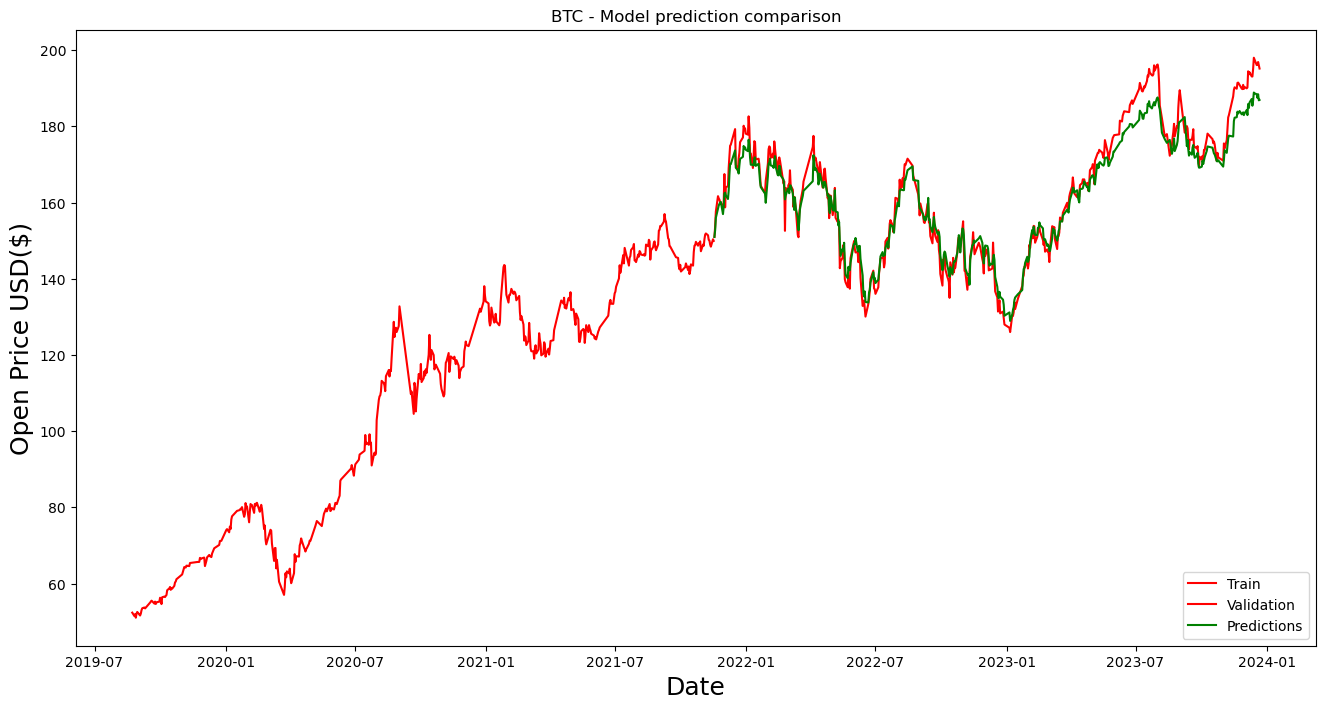

In [159]:
# Plot results
training_data_len = math.ceil(len(df)*.8)
train = df[:training_data_len]
valid = df[training_data_len:]

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
rmse = np.sqrt(mean_squared_error(valid[target_column], predictions))
print(rmse)

#plot the data
open_predictions = predictions
valid['predictions'] = open_predictions
plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train[target_column][-len(valid):] , color='red')
plt.plot(valid[target_column] , color='red')
plt.plot(valid['predictions'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()                        


In [160]:
# Now, we want to check and see if the model is able to predict the DIRECTION of open accurately for each unseen day

actual = list(valid[target_column])
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(1,len(predictions)):
    prev = actual[i-1]
    today = actual[i]
    prev_pred = predictions[i-1]
    today_pred = predictions[i]
    actual_gap = today - prev
    pred_gap = today_pred - prev_pred
    if actual_gap > 0 and pred_gap > 0:
        TP += 1
    elif actual_gap < 0 and pred_gap < 0:
        TN += 1
    elif actual_gap < 0 and pred_gap > 0:
        FP += 1
    elif actual_gap > 0 and pred_gap < 0:
        FN += 1
print(len(predictions))
print(TP,TN,FP,FN)   


460
174 156 63 65


## Now, we will create another model to predict the close price

In [161]:
target_column = 'close'
target_variable = 'next_' + target_column

rmse_all, rmse_features = get_kbest_features(df, target_column)
curr_best_k = len(rmse_features[rmse_all.index(min(rmse_all))]) - 1
#model = models[rmse_all.index(min(rmse_all))]

Selected Features: ['close']
Epoch 1/30
56/56 [==============================] - 2s 18ms/step - loss: 0.0075
Epoch 2/30
56/56 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 3/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 4/30
56/56 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 5/30
56/56 [==============================] - 1s 19ms/step - loss: 9.2186e-04
Epoch 6/30
56/56 [==============================] - 1s 19ms/step - loss: 9.5196e-04
Epoch 7/30
56/56 [==============================] - 1s 19ms/step - loss: 9.2444e-04
Epoch 8/30
56/56 [==============================] - 1s 19ms/step - loss: 7.9493e-04
Epoch 9/30
56/56 [==============================] - 1s 19ms/step - loss: 7.6324e-04
Epoch 10/30
56/56 [==============================] - 1s 19ms/step - loss: 8.6766e-04
Epoch 11/30
56/56 [==============================] - 1s 19ms/step - loss: 7.5052e-04
Epoch 12/30
56/56 [==============================] - 1s 19ms/

In [162]:
target_column = 'close'
target_variable = 'next_' + target_column

temp_df = df.copy()
temp_df[target_variable] = temp_df[target_column].shift(-1)
temp_df = temp_df.dropna() 
features = [col for col in temp_df.columns if col != target_variable]

# Split the data into features (X) and the target variable (y)
X = temp_df[features]
y = temp_df[target_variable]

# Standardize the features (important for feature selection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a SelectKBest model with the desired number of top features, other than the target column (e.g., k=10)
k_best = SelectKBest(score_func=f_regression, k=curr_best_k)  
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Normalize all columns
scaler = StandardScaler()#MinMaxScaler(feature_range=(0, 1))
if target_column in selected_features:
    selected_features.remove(target_column)
selected_features.append(target_column)
print("Selected Features:", selected_features)
scaled_data = scaler.fit_transform(df[selected_features])

prices = scaled_data[:, -1]  # Extracting the normalized target column
sequence_length = 60  # Number of days to consider

training_data_len = math.ceil(len(scaled_data)*.8)
train_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - sequence_length: , : ]

X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# Model creation
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(units=20))
model.add(Dropout(0.2))  
# model.add(Dense(units=25))
# model.add(Dropout(0.2))  
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)


Selected Features: ['vwap', 'close']
Epoch 1/100
56/56 [==============================] - 2s 12ms/step - loss: 0.0813
Epoch 2/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0247
Epoch 3/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0174
Epoch 4/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0164
Epoch 5/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0145
Epoch 6/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0150
Epoch 7/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0129
Epoch 8/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0127
Epoch 9/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0133
Epoch 10/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0124
Epoch 11/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0108
Epoch 12/100
56/56 [==============================] - 1s 12ms/step - l

15/15 [==============================] - 0s 3ms/step
6.604746346476291


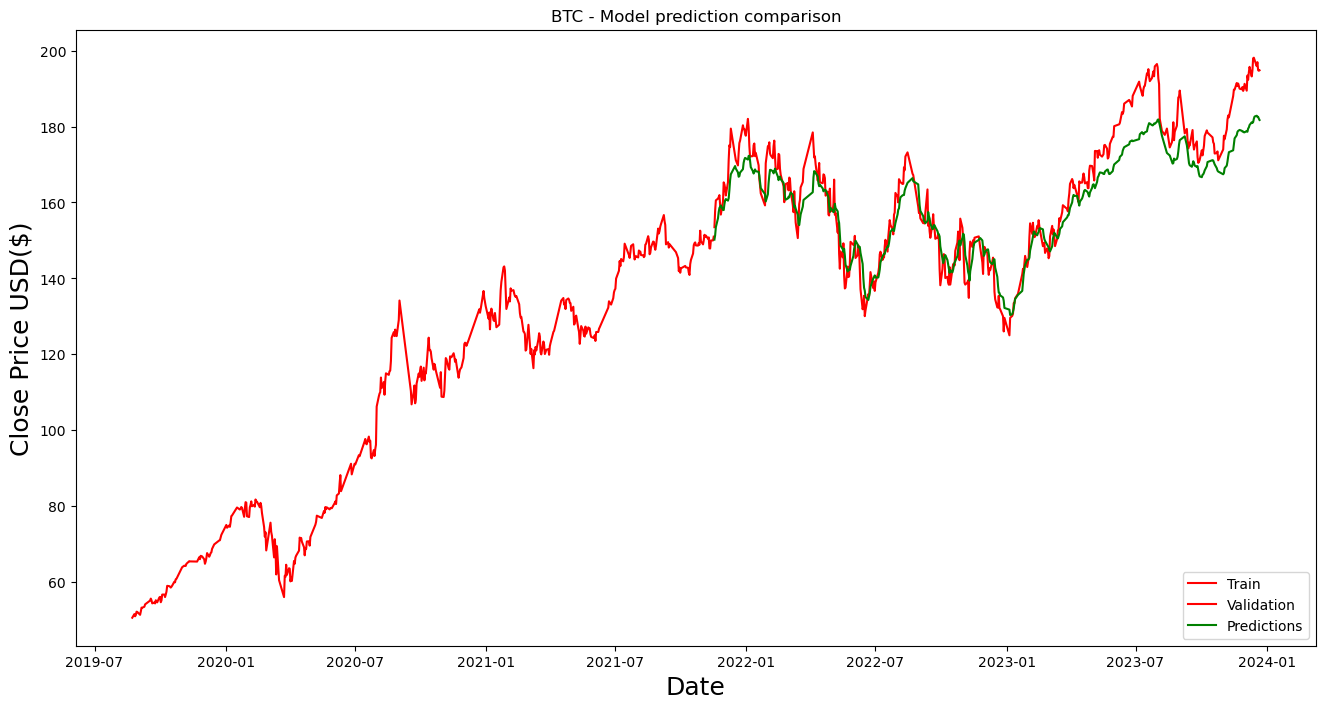

In [163]:
# Plot results
training_data_len = math.ceil(len(df)*.8)
train = df[:training_data_len]
valid = df[training_data_len:]

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
rmse = np.sqrt(mean_squared_error(valid[target_column], predictions))
print(rmse)

#plot the data
close_predictions = predictions
valid['predictions'] = close_predictions
plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train[target_column][-len(valid):] , color='red')
plt.plot(valid[target_column] , color='red')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()                        


In [164]:
# Now, we want to check and see if the model is able to predict the DIRECTION of open accurately for each unseen day

actual = list(valid[target_column])
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(1,len(predictions)):
    prev = actual[i-1]
    today = actual[i]
    prev_pred = predictions[i-1]
    today_pred = predictions[i]
    actual_gap = today - prev
    pred_gap = today_pred - prev_pred
    if actual_gap > 0 and pred_gap > 0:
        TP += 1
    elif actual_gap < 0 and pred_gap < 0:
        TN += 1
    elif actual_gap < 0 and pred_gap > 0:
        FP += 1
    elif actual_gap > 0 and pred_gap < 0:
        FN += 1
print(len(predictions))
print(TP,TN,FP,FN)   


460
128 95 124 112


## Next, we create a model to predict the daily returns

3.6911384223230117


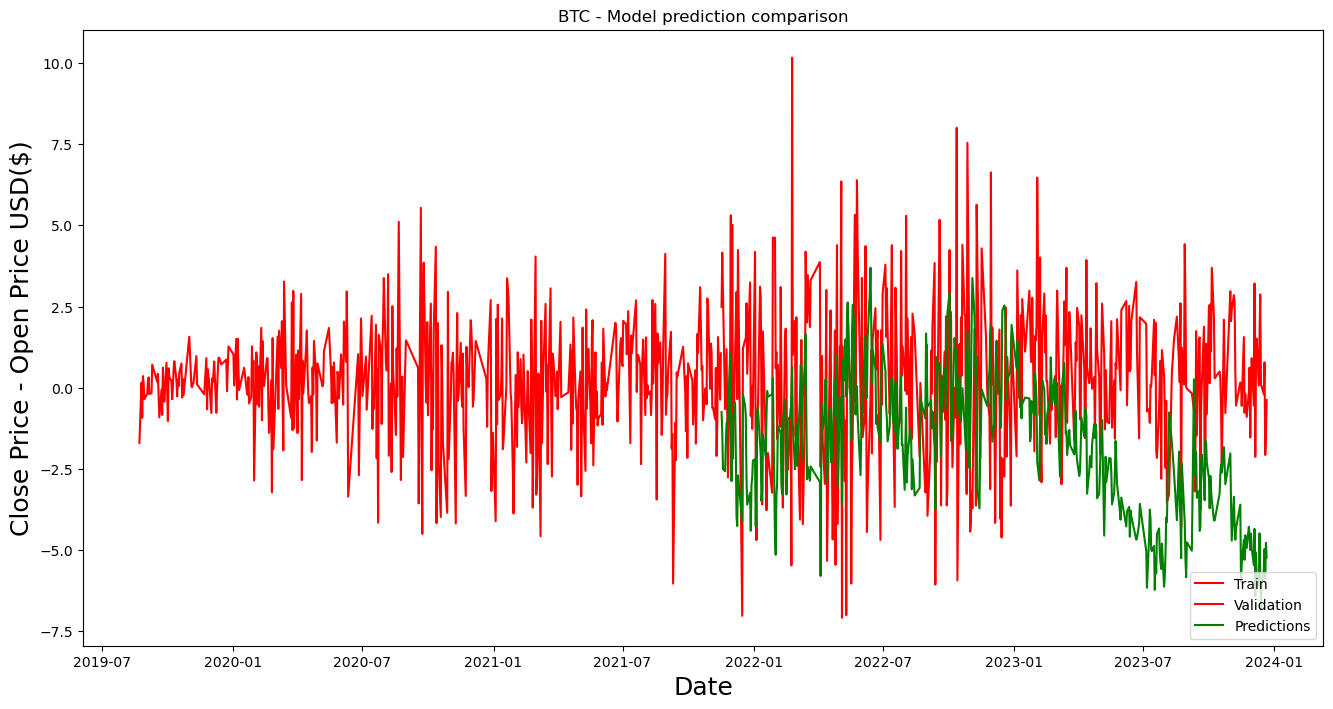

In [165]:
train = df[:training_data_len]
valid = df[training_data_len:]

# now, we calculate the close-open price everyday
train_diff = train['close'] - train['open']
valid_diff = valid['close'] - valid['open']
prediction_diff = close_predictions - open_predictions
rmse = np.sqrt(mean_squared_error(valid_diff, prediction_diff))
print(rmse)

#plot the data
train['openclose_diff'] = train_diff
valid['openclose_diff'] = valid_diff
valid['predictions_diff'] = prediction_diff

plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price - Open Price USD($)', fontsize=18)
plt.plot(train['openclose_diff'][-len(valid):] , color='red')
plt.plot(valid['openclose_diff'] , color='red')
plt.plot(valid['predictions_diff'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show() 

In [166]:
# target_column = 'returns'
# target_variable = 'next_' + target_column
# curr_best_k = 10

In [167]:
# temp_df = df.copy()
# temp_df[target_variable] = temp_df[target_column].shift(-1)
# temp_df = temp_df.dropna() 
# features = [col for col in temp_df.columns if col != target_variable]

# # Split the data into features (X) and the target variable (y)
# X = temp_df[features]
# y = temp_df[target_variable]

# # Standardize the features (important for feature selection)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Create a SelectKBest model with the desired number of top features, other than the target column (e.g., k=10)
# k_best = SelectKBest(score_func=f_regression, k=10)  
# X_train_kbest = k_best.fit_transform(X_train, y_train)
# X_test_kbest = k_best.transform(X_test)

# # Get the indices of the selected features
# selected_feature_indices = k_best.get_support(indices=True)

# # Get the names of the selected features
# selected_features = [features[i] for i in selected_feature_indices]

# # Normalize all columns
# scaler = MinMaxScaler(feature_range=(0, 1))
# if target_column in selected_features:
#     selected_features.remove(target_column)
# selected_features.append(target_column)
# print("Selected Features:", selected_features)
# scaled_data = scaler.fit_transform(df[selected_features])

# prices = scaled_data[:, -1]  # Extracting the normalized target column
# sequence_length = 60  # Number of days to consider

# training_data_len = math.ceil(len(scaled_data)*.8)
# train_data = scaled_data[0:training_data_len,:]
# test_data = scaled_data[training_data_len - sequence_length: , : ]

# X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
# X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# # Model creation
# model = Sequential()
# model.add(LSTM(units=curr_best_k, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))  
# model.add(LSTM(units=curr_best_k*10))
# model.add(Dropout(0.2))  
# # model.add(Dense(units=25))
# # model.add(Dropout(0.2))  
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# model.fit(X_train, y_train, epochs=100, batch_size=32)
